## Very good paper about omics dimensionality reduction 
https://academic.oup.com/bib/article/17/4/628/2240645

In [1]:
import time
from collections import defaultdict
import json
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'  # https://stackoverflow.com/questions/34387893/output-matplotlib-figure-to-svg-with-text-as-text-not-curves
plt.style.use('seaborn-ticks')

import seaborn as sns
import dateutil
from scipy.stats import spearmanr, pearsonr, kendalltau
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, fcluster, fclusterdata

from sklearn.cross_decomposition import PLSRegression, CCA
from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration
from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import (
    cross_val_score, cross_val_predict,
    RepeatedKFold, RepeatedStratifiedKFold,
    train_test_split, 
    GridSearchCV,
    LeaveOneGroupOut,
)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    classification_report,
    roc_auc_score, roc_curve, RocCurveDisplay, auc,
    confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay,
    f1_score, 
    recall_score,
    accuracy_score,
    precision_score, precision_recall_curve, precision_recall_fscore_support,
    #     plot_roc_curve,
    #     plot_precision_recall_curve,  ## The plot_x_score API is deprecated
)
import sklearn
print(sklearn.__version__)

1.0.2


In [3]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic =     [1076, 1082, 1101]
impaired =     [1060, 1062, 1074, 1092, 1102]
normal =       [1091, 1093]
animal_tol = {
    1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic', 1060: 'impaired', 1062: 'impaired', 
    1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal'}
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='FBG|RBG').columns
fbg_cols = data.filter(regex='FBG').columns
rbg_cols = data.filter(regex='RBG').columns
pval_cols = data.filter(regex='pval').columns

In [4]:
# X_all = pd.DataFrame(StandardScaler().fit_transform(data[data_cols].T), index=data_cols, columns=data.index)

X_all = data[data_cols].T

y_3class = fg['gluc_tol']                                                 # ['normal', 'impaired', 'diabetic']
y_3class_num = y_3class.map({'normal': 0, 'impaired': 1, 'diabetic': 2})  # [0, 1, 2]
y_bg = fg['bg']                                                           # random/fasted blood glucoose
y_ogtt = fg['animal'].map(ap['OGTT (AUC)'])
y_weight = fg['animal'].map(ap['Weightprefastweek12'])
y_insulin = fg['animal'].map(ap['Insulin (AUC)'])

# PLS Regression is supervised regression. PLS-DA is the extension into classification

## Good examples
https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html#sphx-glr-auto-examples-cross-decomposition-plot-pcr-vs-pls-py
https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_compare_cross_decomposition.html#sphx-glr-auto-examples-cross-decomposition-plot-compare-cross-decomposition-py

# In general, you do not need to center or standardize X for multiple regression: 
https://stats.stackexchange.com/questions/29781/when-conducting-multiple-regression-when-should-you-center-your-predictor-varia

## The results from PCA and CCA are identical regardless of StandardScale or not


In [98]:
def pls_reg(subset):
    plsr = PLSRegression(n_components=5, max_iter=1000).fit(X_all.loc[subset], y_ogtt.loc[subset])

    df = pd.DataFrame(plsr.x_loadings_, index=data.index)
    df['coef'] = plsr.coef_
    df = df.join(data[data.columns[0:11]])
    df = df.loc[(df['ID'] != 'unknown') & (df['Type'] == 'lipid')]
    df['superclass'] = df['molec_class'].apply(lambda x: colors[x]['superclass'])
    return df

In [99]:
d = {}
for subset, name in zip([data_cols, rbg_cols, fbg_cols], ['all', 'rbg', 'fbg']):
    
    d[name] = pls_reg(subset)

In [102]:
d['fbg']

,0,1,2,3,4,coef,unique_id,RT,m/z,adduct,Type,polarity,ID,molec_class,qval_sampling,qval_ogtt,qval_sampling:ogtt,superclass
i,,,,,,,,,,,,,,,,,,
l_5,0.031911,-0.009666,0.036184,0.041897,-0.007229,-47.565540,LysoPC 20:5_1.036_542.32452,1.036,542.32452,NaN,lipid,+,LysoPC 20:5,LysoPC,1.109700e-03,0.016438,0.656878,Phospholipid
l_6,0.001986,-0.004779,0.026633,0.001243,-0.008241,6.203681,LysoPC 16:0_1.095_496.33994,1.095,496.33994,NaN,lipid,+,LysoPC 16:0,LysoPC,5.693703e-01,0.719292,0.643840,Phospholipid
l_7,0.014487,-0.024271,0.028920,0.011423,-0.030761,-20.073702,LysoPC 18:1_1.137_522.35236,1.137,522.35236,NaN,lipid,+,LysoPC 18:1,LysoPC,8.215505e-07,0.099402,0.885658,Phospholipid
l_9,0.015213,-0.002117,0.001485,-0.007195,-0.042824,31.497675,LysoPC 22:6_1.289_568.33972,1.289,568.33972,NaN,lipid,+,LysoPC 22:6,LysoPC,2.505468e-01,0.173395,0.667137,Phospholipid
l_10,0.024605,-0.002600,0.023758,0.013856,-0.031235,-12.587111,LysoPC 15:0_1.324_482.32388,1.324,482.32388,NaN,lipid,+,LysoPC 15:0,LysoPC,1.815410e-02,0.035110,0.894460,Phospholipid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
l_861,-0.007138,-0.049565,0.044392,-0.004976,-0.020775,-27.383903,TG 57:2_19.582_946.88043,19.582,946.88043,NaN,lipid,+,TG 57:2,TG,1.722141e-01,0.118692,0.013714,Glycerolipid
l_863,0.002048,-0.045222,0.043696,-0.002682,-0.033339,-27.230700,TG 56:1_19.841_934.88123,19.841,934.88123,NaN,lipid,+,TG 56:1,TG,7.148915e-05,0.089175,0.001454,Glycerolipid
l_864,0.000574,-0.039832,0.030811,-0.005902,-0.055088,-4.194102,TG 18:2_18:1_24:0_19.865_986.91193,19.865,986.91193,NaN,lipid,+,TG 18:2_18:1_24:0,TG,1.600629e-06,0.049878,0.001979,Glycerolipid


C:\Users\bjanderson23\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='0', ylabel='0'>

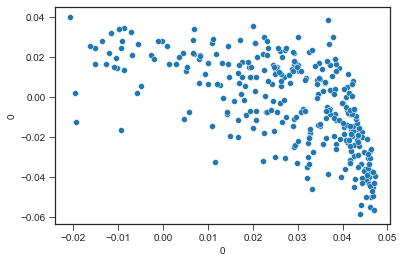

In [113]:
sns.scatterplot(d['rbg'][0], d['fbg'][0])

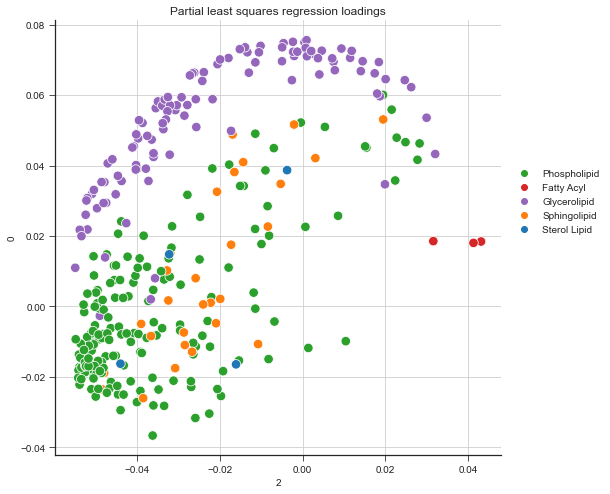

In [88]:
fig, ax = plt.subplots(figsize=(8,8))
plt.title('Partial least squares regression loadings')

sns.scatterplot(
    data=df, x=2, y=0, hue='superclass',
    s=90, 
    palette=colors
)
plt.grid()
plt.legend(loc=(1.02, 0.5))
sns.despine()

In [138]:
ld = {}  # ld = LeaveOneGroupOut Dictionary

for columns, column_name in zip([rbg_cols, fbg_cols], ['RBG', 'FBG']):
    X = X_all.loc[columns]
    ld[column_name] = {}
    for y_data, y_name in (
        [y_ogtt, 'ogtt'], 
#         [y_weight, 'weight'], 
#         [y_insulin, 'insulin']
    ):
        y = y_data.loc[columns]
        ld[column_name][y_name] = {}
        
        for est, model_name in [(PLSRegression(n_components=1), 'pls'), (CCA(n_components=1), 'cca')]:
            d = ld[column_name][y_name][model_name] = {}
            d['feat_imp'] = 0
            d['y_true'] = []
            d['y_pred'] = []
            logo = LeaveOneGroupOut()
            for train, test in logo.split(X, y, groups=X.index.map(fg['animal'])):
                model = est.fit(X.iloc[train], y.iloc[train])
                y_pred = model.predict(X.iloc[test])
                d['feat_imp'] += model.coef_
                d['y_true'].extend(y.iloc[test])
                d['y_pred'].extend([val[0] for val in y_pred])

In [139]:
rp = ld['RBG']['ogtt']['pls']
fp = ld['FBG']['ogtt']['pls']
rc = ld['RBG']['ogtt']['cca']
fc = ld['FBG']['ogtt']['cca']

Text(0.5, 1.0, 'Fasted PLS\nMean absolute percentage error: 20.0%')

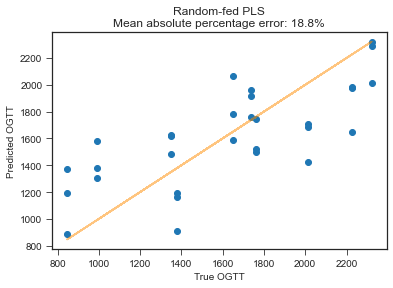

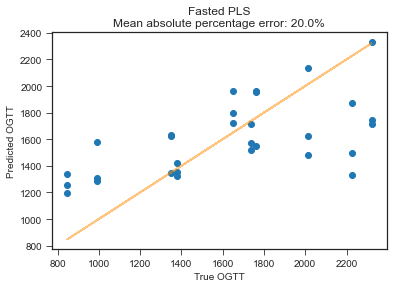

In [156]:
df = rp
y_true = np.array(df['y_true'])
y_pred = np.array(df['y_pred'])
resid = y_true - y_pred
plt.scatter(y_true, y_pred)
plt.plot(y_ogtt.loc[rbg_cols], y_ogtt.loc[rbg_cols], c='darkorange', alpha=0.5)
plt.xlabel('True OGTT')
plt.ylabel('Predicted OGTT')
mean_perc_error = round(abs(resid / y_true).mean(), 3) * 100
plt.title(f'Random-fed PLS\nMean absolute percentage error: {mean_perc_error}%')

plt.figure()

df = fp
y_true = np.array(df['y_true'])
y_pred = np.array(df['y_pred'])
resid = y_true - y_pred
plt.scatter(y_true, y_pred)
plt.plot(y_ogtt.loc[rbg_cols], y_ogtt.loc[rbg_cols], c='darkorange', alpha=0.5)
plt.xlabel('True OGTT')
plt.ylabel('Predicted OGTT')
mean_perc_error = round(abs(resid / y_true).mean(), 3) * 100
plt.title(f'Fasted PLS\nMean absolute percentage error: {mean_perc_error}%')

In [151]:
plscoef = pd.DataFrame({'RBGpls': rp['feat_imp'][:, 0], 'FBGpls': fp['feat_imp'][:, 0],})
plscoef

# plscoef.to_csv(r'..\models\feat_importances\pls_regression_feature_importances.csv')

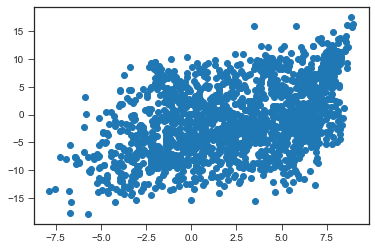

In [150]:
plt.scatter(plscoef['RBGpls'], plscoef['FBGpls'])

Text(0.5, 1.0, 'Distribution of coefficients for PLS Regression')

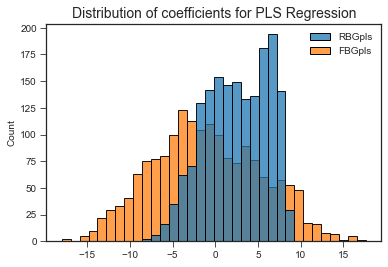

In [152]:
sns.histplot(plscoef)
plt.title('Distribution of coefficients for PLS Regression', fontsize=14)

### CCA is terrible. It predicts -7000 for some OGTT values

# regular CCA is limited to n > p, and does not do feature selection
### but other CCAs (sparse CCA, penalized CCA) can do feature selection 
https://academic.oup.com/bib/article/17/4/628/2240645


In [159]:
# df = rc
# y_true = np.array(df['y_true'])
# y_pred = np.array(df['y_pred'])
# resid = y_true - y_pred
# plt.scatter(y_true, y_pred)
# plt.plot(y_ogtt.loc[rbg_cols], y_ogtt.loc[rbg_cols], c='darkorange', alpha=0.5)
# plt.xlabel('True OGTT')
# plt.ylabel('Predicted OGTT')
# mean_perc_error = round(abs(resid / y_true).mean(), 3) * 100
# plt.title(f'Random-fed PLS\nMean absolute percentage error: {mean_perc_error}%')

# plt.figure()

# df = fc
# y_true = np.array(df['y_true'])
# y_pred = np.array(df['y_pred'])
# resid = y_true - y_pred
# plt.scatter(y_true, y_pred)
# plt.plot(y_ogtt.loc[rbg_cols], y_ogtt.loc[rbg_cols], c='darkorange', alpha=0.5)
# plt.xlabel('True OGTT')
# plt.ylabel('Predicted OGTT')
# mean_perc_error = round(abs(resid / y_true).mean(), 3) * 100
# plt.title(f'Random-fed PLS\nMean absolute percentage error: {mean_perc_error}%')

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_ogtt, test_size=0.1, random_state=1)

pls = PLSRegression(n_components=20).fit(X_all.loc[rbg_cols], y_ogtt.loc[rbg_cols])
cca = CCA(n_components=1).fit(X_all.loc[rbg_cols], y_ogtt.loc[rbg_cols])

pls.coef_
cca.coef_

array([[ 13.32249139],
       [ 10.49394781],
       [  2.23460843],
       ...,
       [-13.58078583],
       [ -9.78616076],
       [-23.33105822]])

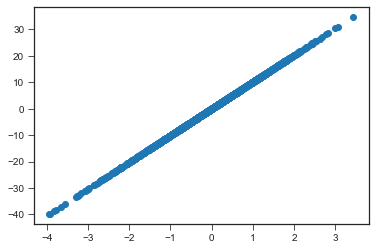

In [131]:
plt.scatter(pls.coef_, cca.coef_)

In [132]:
coefs = pd.DataFrame({'pls': pls.coef_[:, 0], 'cca': cca.coef_[:, 0]}, index=data.index)
display(coefs)
# coefs.to_csv(r'..\data\processed\PLS_CCA_coefficients.csv')

,pls,cca
i,,
l_0,1.315299,13.322491
l_1,1.036044,10.493948
l_2,0.220618,2.234608
l_3,-0.134158,-1.358870
l_4,0.087439,0.885663
...,...,...
m_169,-3.568107,-36.140882
m_213,-0.833284,-8.440222
m_24,-1.340800,-13.580786


In [107]:
pls.x_scores_.shape

(60, 20)

In [110]:
pls.predict(X_all)

array([[ 846.79139076],
       [ 846.72870009],
       [ 846.74373474],
       [ 993.0152532 ],
       [ 993.04815883],
       [ 993.07237432],
       [1761.77988734],
       [1761.69851686],
       [1761.67774109],
       [1648.81918916],
       [1648.80535111],
       [1648.72076514],
       [1350.245693  ],
       [1350.35066283],
       [1350.25858552],
       [1377.90803438],
       [1377.89210031],
       [1377.96677398],
       [1738.28566472],
       [1738.15436426],
       [1738.31602583],
       [2321.26275925],
       [2321.21605182],
       [2321.29861271],
       [2224.78612225],
       [2224.67184857],
       [2224.81803689],
       [2015.75279199],
       [2015.74926373],
       [2015.62653605],
       [ 846.70030477],
       [ 846.76229902],
       [ 846.79476615],
       [ 992.95633743],
       [ 992.99434746],
       [ 992.87615894],
       [1761.62317534],
       [1761.78557729],
       [1761.78027674],
       [1648.74512679],
       [1648.66008077],
       [1648.784

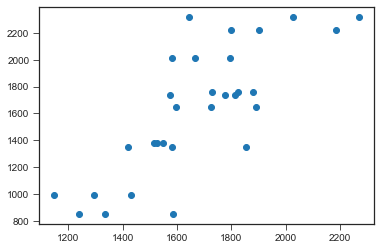

In [135]:
plt.scatter(pls.predict(X_all.loc[fbg_cols]), y_ogtt.loc[fbg_cols])
# plt.gcf().set_size_inches(10, 4)

In [73]:
pls.x_weights_.shape

(1727, 10)

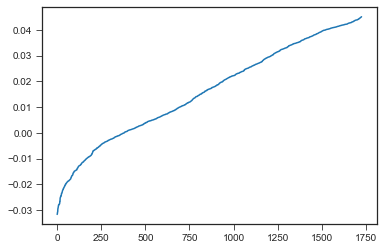

In [136]:
plt.plot(range(1727), np.sort(pls.x_loadings_[:, 0]))

In [95]:
pls.y_scores_.shape

(60, 10)

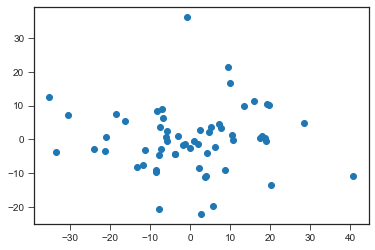

In [93]:
plt.scatter(pls.x_scores_[:, 0], pls.x_scores_[:, 1])

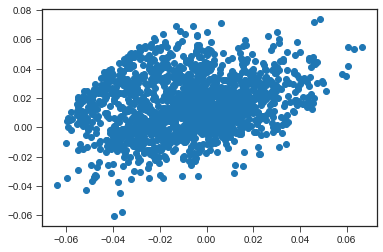

In [109]:
plt.scatter(pls.x_weights_[:, 0], pls.x_weights_[:, 1])